Using FinRED dir: C:\Users\shaha\OneDrive\Desktop\IITB\thirdyear\EE782\proj\ee782_re_project\data\FinRED
[train] loaded 5700 examples from finred_train.txt
[dev] loaded 1007 examples from finred_dev.txt
[test] loaded 1068 examples from finred_test.txt
Relation types from finred_relations.txt (29):
['product/material produced', 'manufacturer', 'distributed by', 'industry', 'position held', 'original broadcaster', 'owned by', 'founded by', 'distribution format', 'headquarters location', 'stock exchange', 'currency', 'parent organization', 'chief executive officer', 'director/manager', 'owner of', 'operator', 'member of', 'employer', 'chairperson', 'platform', 'subsidiary', 'legal form', 'publisher', 'developer', 'brand', 'business division', 'location of formation', 'creator']

=== Split: train ===
Examples: 5700
Total triples: 8079
Unique relations: 29
Top relations:
  product_or_material_produced     1373
  industry                         1167
  owned_by                          673
 

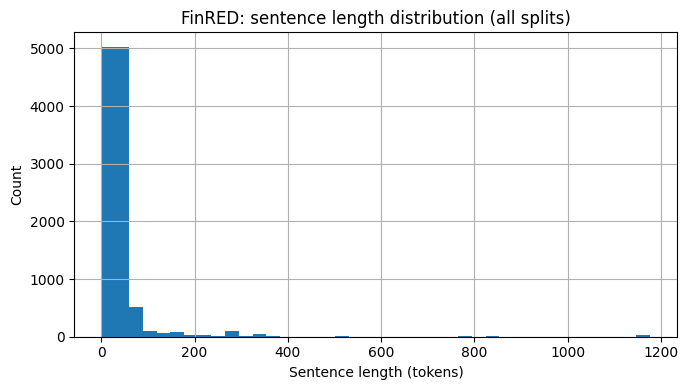

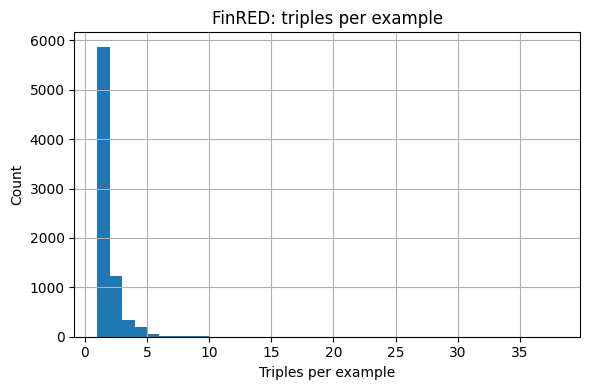

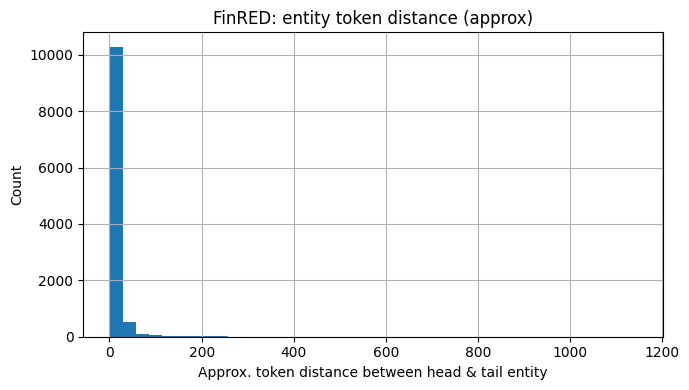

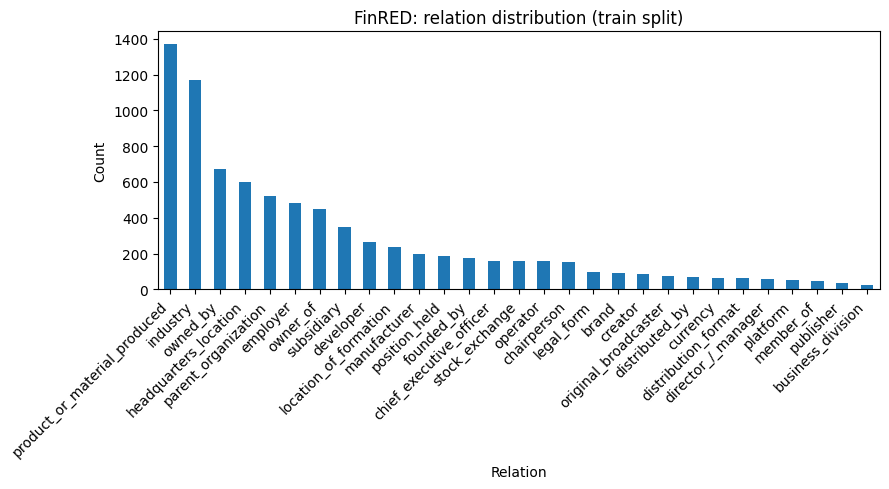

Saved flat FinRED CSV to: C:\Users\shaha\OneDrive\Desktop\IITB\thirdyear\EE782\proj\ee782_re_project\data\FinRED\finred_flat.csv


In [1]:
# FinRED dataset analysis – Jupyter notebook cell

from pathlib import Path
from collections import Counter, defaultdict
import statistics as stats
import re

import pandas as pd
import matplotlib.pyplot as plt

# -----------------------
# 1. Paths & basic setup
# -----------------------

# Change this if your structure is different
DATA_DIR = Path("data")
FINRED_DIR = DATA_DIR / "finred"

TRAIN_PATH = FINRED_DIR / "finred_train.txt"
DEV_PATH   = FINRED_DIR / "finred_dev.txt"
TEST_PATH  = FINRED_DIR / "finred_test.txt"
REL_PATH   = FINRED_DIR / "finred_relations.txt"

print("Using FinRED dir:", FINRED_DIR.resolve())

# -----------------------
# 2. Helper: parse one line
# -----------------------

def parse_finred_line(line: str):
    """
    FinRED line format:

      <sentence> | <ent1> ; <ent2> ; <relation> | <ent1> ; <ent2> ; <relation> ...

    Returns:
      {
        "sentence": <str>,
        "triples": [
          {"head": <str>, "tail": <str>, "relation": <str>},
          ...
        ]
      }
    """
    line = line.strip()
    if not line:
        return None

    parts = [p.strip() for p in line.split(" | ")]
    if not parts:
        return None

    sentence = parts[0]
    triples = []
    for p in parts[1:]:
        if not p:
            continue
        fields = [f.strip() for f in p.split(" ; ")]
        if len(fields) != 3:
            # If the format is weird, just skip this relation and optionally debug-print
            # print("Weird triple part:", repr(p))
            continue
        head, tail, rel = fields
        triples.append({"head": head, "tail": tail, "relation": rel})

    return {"sentence": sentence, "triples": triples}


# -----------------------
# 3. Load a split
# -----------------------

def load_split(path: Path, split_name: str):
    data = []
    with path.open(encoding="utf-8") as f:
        for i, line in enumerate(f, start=1):
            ex = parse_finred_line(line)
            if ex is None:
                continue
            ex["id"] = f"{split_name}_{i}"
            data.append(ex)
    print(f"[{split_name}] loaded {len(data)} examples from {path.name}")
    return data

train_data = load_split(TRAIN_PATH, "train")
dev_data   = load_split(DEV_PATH,   "dev")
test_data  = load_split(TEST_PATH,  "test")

splits = {"train": train_data, "dev": dev_data, "test": test_data}

# -----------------------
# 4. Load relation schema
# -----------------------

with REL_PATH.open(encoding="utf-8") as f:
    relation_schema = [ln.strip() for ln in f if ln.strip()]
print(f"Relation types from finred_relations.txt ({len(relation_schema)}):")
print(relation_schema)

# -----------------------
# 5. Basic stats per split
# -----------------------

def basic_split_stats(split_name, data):
    n_examples = len(data)
    n_triples  = sum(len(ex["triples"]) for ex in data)
    rel_counter = Counter(t["relation"] for ex in data for t in ex["triples"])
    print(f"\n=== Split: {split_name} ===")
    print("Examples:", n_examples)
    print("Total triples:", n_triples)
    print("Unique relations:", len(rel_counter))
    print("Top relations:")
    for rel, c in rel_counter.most_common(10):
        print(f"  {rel:30s} {c:6d}")

for split_name, data in splits.items():
    basic_split_stats(split_name, data)


# -----------------------
# 6. Sentence length, triples per example, entity distances
# -----------------------

def approx_entity_token_pos(sentence: str, entity: str):
    """
    Rough approximation: find the first char index of the entity string
    in the sentence (case-insensitive), and convert to token index by
    counting tokens before that char.

    Returns None if the entity substring is not found.
    """
    s_lower = sentence.lower()
    e_lower = entity.lower()
    idx = s_lower.find(e_lower)
    if idx == -1:
        return None

    # Count tokens before char index idx
    prefix = sentence[:idx]
    # Split on whitespace; this is crude but ok for dataset-level stats
    tokens_before = len(prefix.split())
    return tokens_before

rows = []
for split_name, data in splits.items():
    for ex in data:
        sent = ex["sentence"]
        sent_tokens = sent.split()
        sent_len = len(sent_tokens)
        num_triples = len(ex["triples"])

        # If an example has no triples (shouldn't happen but be safe)
        if num_triples == 0:
            rows.append({
                "split": split_name,
                "id": ex["id"],
                "sentence": sent,
                "head": None,
                "tail": None,
                "relation": None,
                "sent_len": sent_len,
                "num_triples": num_triples,
                "entity_token_distance": None,
            })
            continue

        for t in ex["triples"]:
            head, tail, rel = t["head"], t["tail"], t["relation"]

            # Approximate entity token positions
            h_pos = approx_entity_token_pos(sent, head)
            t_pos = approx_entity_token_pos(sent, tail)
            if h_pos is not None and t_pos is not None:
                ent_dist = abs(h_pos - t_pos)
            else:
                ent_dist = None

            rows.append({
                "split": split_name,
                "id": ex["id"],
                "sentence": sent,
                "head": head,
                "tail": tail,
                "relation": rel,
                "sent_len": sent_len,
                "num_triples": num_triples,
                "entity_token_distance": ent_dist,
            })

df = pd.DataFrame(rows)
print("\nFlat dataframe shape:", df.shape)
df.head()

# -----------------------
# 7. Aggregate stats from the DataFrame
# -----------------------

def describe_numeric(series, name):
    series = series.dropna()
    if series.empty:
        print(f"{name}: no data")
        return
    print(f"{name}:")
    print(f"  count = {len(series)}")
    print(f"  mean  = {series.mean():.2f}")
    print(f"  std   = {series.std():.2f}")
    print(f"  min   = {series.min():.2f}")
    print(f"  25%   = {series.quantile(0.25):.2f}")
    print(f"  50%   = {series.median():.2f}")
    print(f"  75%   = {series.quantile(0.75):.2f}")
    print(f"  max   = {series.max():.2f}")

print("\n=== Global numeric stats (all splits) ===")
describe_numeric(df["sent_len"], "Sentence length (tokens)")
describe_numeric(df["num_triples"], "Triples per example")
describe_numeric(df["entity_token_distance"], "Entity token distance (approx)")

print("\n=== Per-split sentence length stats ===")
for split_name in splits.keys():
    print(f"\nSplit: {split_name}")
    describe_numeric(df.loc[df["split"] == split_name, "sent_len"], "Sentence length")

print("\n=== Per-split triples-per-example stats ===")
triples_per_ex = df.groupby(["split", "id"])["relation"].count().reset_index(name="n_triples")
for split_name in splits.keys():
    print(f"\nSplit: {split_name}")
    describe_numeric(triples_per_ex.loc[triples_per_ex["split"] == split_name, "n_triples"],
                     "Triples per example")


# -----------------------
# 8. Relation distributions (overall + per split)
# -----------------------

print("\n=== Overall relation distribution ===")
overall_rel_counts = df["relation"].value_counts()
print(overall_rel_counts)

print("\n=== Per-split relation distribution (top 10) ===")
for split_name in splits.keys():
    print(f"\nSplit: {split_name}")
    rel_counts = df.loc[df["split"] == split_name, "relation"].value_counts()
    print(rel_counts.head(10))


# -----------------------
# 9. Plots
# -----------------------

FINRED_DIR.mkdir(parents=True, exist_ok=True)

# (a) Sentence length histogram
plt.figure(figsize=(7, 4))
df["sent_len"].hist(bins=40)
plt.xlabel("Sentence length (tokens)")
plt.ylabel("Count")
plt.title("FinRED: sentence length distribution (all splits)")
plt.tight_layout()
plt.show()

# (b) Triples per example histogram
plt.figure(figsize=(6, 4))
triples_per_ex["n_triples"].hist(bins=range(1, triples_per_ex["n_triples"].max() + 2))
plt.xlabel("Triples per example")
plt.ylabel("Count")
plt.title("FinRED: triples per example")
plt.tight_layout()
plt.show()

# (c) Entity token distance histogram (approx)
plt.figure(figsize=(7, 4))
df["entity_token_distance"].dropna().hist(bins=40)
plt.xlabel("Approx. token distance between head & tail entity")
plt.ylabel("Count")
plt.title("FinRED: entity token distance (approx)")
plt.tight_layout()
plt.show()

# (d) Relation frequency bar chart (train only)
plt.figure(figsize=(9, 5))
train_rel_counts = df.loc[df["split"] == "train", "relation"].value_counts()
train_rel_counts.plot(kind="bar")
plt.xlabel("Relation")
plt.ylabel("Count")
plt.title("FinRED: relation distribution (train split)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# -----------------------
# 10. Save flat CSV for later inspection
# -----------------------

out_csv = FINRED_DIR / "finred_flat.csv"
df.to_csv(out_csv, index=False)
print("Saved flat FinRED CSV to:", out_csv.resolve())
